RL108 - t011
- all optical
- post 4ap
- NAPARM export: 2020-12-18_RL108_ps_009

t11 - photostim experiment #1 (NAPARM export: 2020-12-18_RL108_ps_009); 	
11 cells x 3 groups; 5mW per cell

preset: 2020-12-17_PS_10shots-interleaved (approach #2)

change every: 25ms

shots per pattern: 1

inter-shot interval (ms): 25

spiral duration (ms): 20

delay first spiral (ms): 5

sequence repititions: 10 (750ms total length of stim)

trial length (s): 5

number of trials: 100

paq: 2020-12-18_RL108_011.paq

## RL108 - t011 - alloptical photostim processing

In [1]:
import sys; sys.path.append('/home/pshah/Documents/code/PackerLab_pycharm/')
import os
import pickle
import alloptical_utils_pj as aoutils
import alloptical_plotting as aoplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils.funcs_pj as pj

###### IMPORT pkl file containing expobj
trial = 't-011'
date = '2020-12-18'
pkl_path = "/home/pshah/mnt/qnap/Analysis/%s/%s_%s/%s_%s.pkl" % (date, date, trial, date, trial)

expobj, experiment = aoutils.import_expobj(trial=trial, date=date, pkl_path=pkl_path)

cont_inue = True  # i know this is a rather very precarious thing here...

s2p_path = '/home/pshah/mnt/qnap/Analysis/2020-12-18/suite2p/alloptical-2p-1x-alltrials/plane0'  # (most recent run for RL108 -- contains all trials including post4ap all optical trials)

print('\nExperiment information:\n', expobj.metainfo)

importing expobj for "2020-12-18, t-011" from: /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/2020-12-18_t-011.pkl
DONE IMPORT of RL108: t-011, post 4ap all optical trial

Experiment information:
 {'animal prep.': 'RL108', 'trial': 't-011', 'date': '2020-12-18', 'exptype': 'post 4ap all optical trial', 'data_path_base': '/home/pshah/mnt/qnap/Data/2020-12-18', 'comments': 'should be 5 seizures based on the paq LFP file'}


Loading 692 traces labelled as cells
Subtracting neuropil with a coefficient of 0.7

searching for targeted cells...
(144, 251)
(350, 331)
(336, 322)
(177, 324)
(130, 285)
(329, 94)
(262, 292)
(312, 286)
(130, 358)
(272, 351)
(319, 202)
(355, 178)
(375, 284)
(165, 139)
(354, 316)
(306, 85)
(166, 87)
(338, 384)
(271, 267)
(299, 273)
(134, 259)
(108, 114)
(165, 191)
(312, 47)
(354, 316)
(134, 259)
(432, 240)
------- Search completed.
Number of targeted cells:  27
Target cells found in suite2p:  [0, 1, 2, 5, 7, 17, 27, 31, 47, 51, 54, 60, 63, 137, 140, 143, 170, 176, 187, 274, 328, 375, 461, 641, 783, 802, 2272]  -- 27 cells (out of 34 target coords)


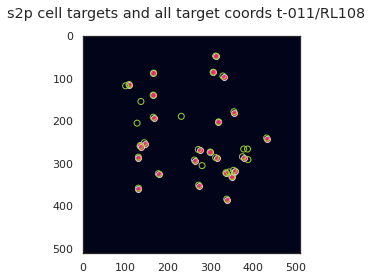

Retrieving s2p masks for: /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/2020-12-18_t-011.pkl              
s2p ROI + photostim targets masks saved to:  /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011_s2p_masks.tif


In [8]:
# %% prep for importing data from suite2p for this whole experiment
# determine which frames to retrieve from the overall total s2p output
trials = ['t-005', 't-006', 't-008', 't-009', 't-010', 't-011', 't-012', 't-013']  # specify all trials that were used in the suite2p run
baseline_trials = ['t-005', 't-006']  # specify which trials to use as spont baseline
# note ^^^ this only works currently when the spont baseline trials all come first, and also back to back
total_frames_stitched = 0
curr_trial_frames = None
baseline_frames = [0, 0]
for t in trials:
    pkl_path_2 = "/home/pshah/mnt/qnap/Analysis/%s/%s_%s/%s_%s.pkl" % (date, date, t, date, t)
    with open(pkl_path_2, 'rb') as f:
        _expobj = pickle.load(f)
        # import suite2p data
    total_frames_stitched += _expobj.n_frames
    if t == trial:
        expobj.curr_trial_frames = [total_frames_stitched - _expobj.n_frames, total_frames_stitched]
    if t in baseline_trials:
        baseline_frames[1] = total_frames_stitched



# suite2p processing on expobj; import suite2p data, flu, spks, cell coordinates and make s2p masks images stack
# s2p_path = '/Users/prajayshah/Documents/data-to-process/2020-12-18/suite2p/alloptical-2p-pre-4ap-08x/plane0'
# flu, spks, stat = uf.s2p_loader(s2p_path, subtract_neuropil=True)


# s2p_path = '/Volumes/Extreme SSD/oxford-data/2020-03-18/suite2p/photostim-4ap_stitched/plane0'

# main function that imports suite2p data and adds attributes to the expobj
expobj.s2pProcessing(s2p_path=s2p_path, subset_frames=expobj.curr_trial_frames, subtract_neuropil=True,
                     baseline_frames=baseline_frames)

expobj.target_coords_all = expobj.target_coords
expobj.s2p_targets()

# expobj.target_coords_all = expobj.target_coords

# flu, expobj.spks, expobj.stat = uf.s2p_loader(s2p_path, subtract_neuropil=True)

aoutils.s2pMaskStack(obj=expobj, pkl_list=[pkl_path], s2p_path=s2p_path,
                     parent_folder='/home/pshah/mnt/qnap/Analysis/2020-12-18/')


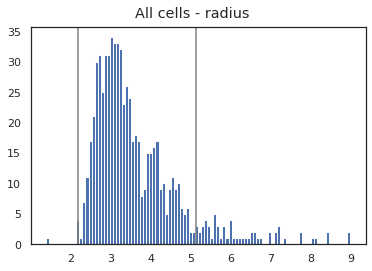

In [2]:
# %% plotting the distribution of radius and aspect ratios - should this be running before the filtering step which is right below????????

radius_list = aoplot.plot_cell_radius_aspectr(expobj, expobj.stat, to_plot='radius')

In [10]:
# %% FILTER ALL CELLS THAT ARE ACTIVE AT LEAST ONCE FOR >2.5*std

# pull out needed variables because numba doesn't work with custom classes (such as this all-optical class object)
cell_ids = expobj.cell_id
raws = expobj.raw
# expobj.append_seizure_frames(bad_frames=None)
photostim_frames = expobj.photostim_frames
radiuses = expobj.radius

# initial quick run to allow numba to compile the function - not sure if this is actually creating time savings
_ = aoutils._good_cells(cell_ids=cell_ids[:3], raws=raws, photostim_frames=expobj.photostim_frames, radiuses=radiuses,
                        std_thresh=2, min_radius_pix=2.5, max_radius_pix=8.5)
expobj.good_cells = aoutils._good_cells(cell_ids=cell_ids, raws=raws, photostim_frames=expobj.photostim_frames,
                                        radiuses=radiuses,
                                        std_thresh=2, min_radius_pix=2.5, max_radius_pix=8.5)


0  out of  3  cells done
# of good cells found:  3  (out of  3  ROIs)
0  out of  692  cells done
100  out of  692  cells done
200  out of  692  cells done
300  out of  692  cells done
400  out of  692  cells done
500  out of  692  cells done
600  out of  692  cells done
# of good cells found:  653  (out of  692  ROIs)


In [11]:
# %% SAVE THE UPDATED expobj OBJECT IN THE ORIGINAL PKL PATH TO USE NEXT

# make the necessary Analysis saving subfolder as well
expobj.analysis_save_path = expobj.tiff_path[:21] + 'Analysis/' + expobj.tiff_path[26:-35]
if os.path.exists(expobj.analysis_save_path):
    pass
elif os.path.exists(expobj.analysis_save_path[:-17]):
    os.mkdir(expobj.analysis_save_path)
elif os.path.exists(expobj.analysis_save_path[:-27]):
    os.mkdir(expobj.analysis_save_path[:-17])


expobj.save_pkl(pkl_path=pkl_path)


print("\n COMPLETED RUNNING ALL OPTICAL PROCESSING PHOTOSTIM.")


pkl saved to /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/2020-12-18_t-011.pkl

 COMPLETED RUNNING ALL OPTICAL PROCESSING PHOTOSTIM.


#### processing steps for SEIZURE TRIALS only!!


 MOVING ONTO POST-4AP SZ PROCESSING
First loading up and plotting baseline (comparison) tiff from:  /home/pshah/mnt/qnap/Data/2020-12-18/2020-12-18_t-005/2020-12-18_t-005_Cycle00001_Ch3.tif


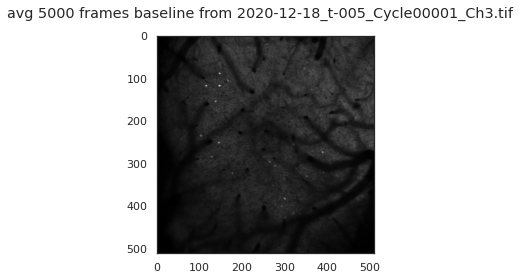

loading up post4ap tiff from:  /home/pshah/mnt/qnap/Data/2020-12-18/2020-12-18_t-011/2020-12-18_t-011_Cycle00001_Ch3.tif
Processing seizures from experiment tiff (wait for all seizure comparisons to be processed), 
 total tiff shape:  (17788, 512, 512)


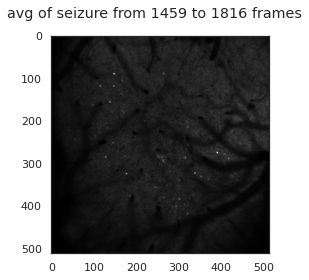

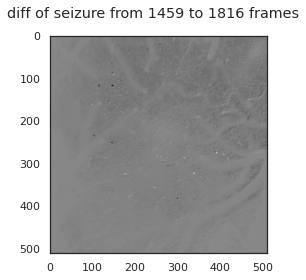

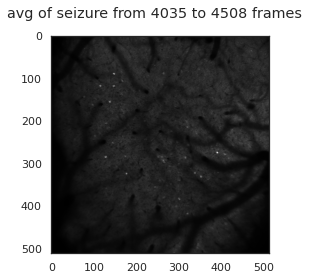

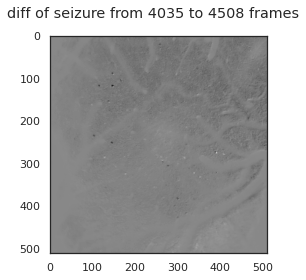

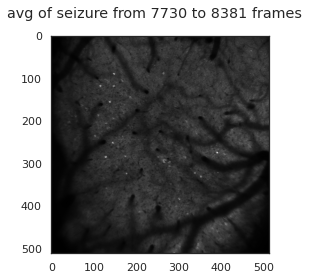

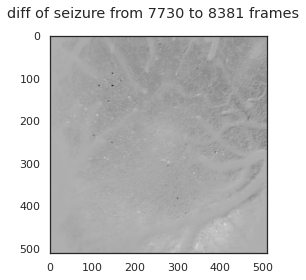

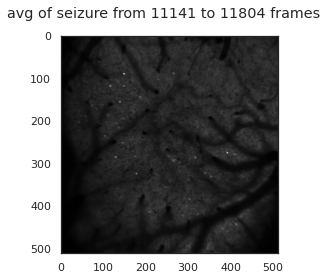

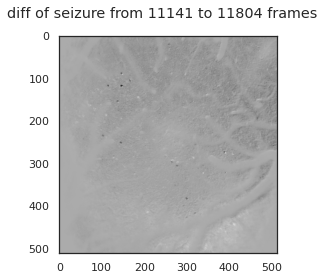

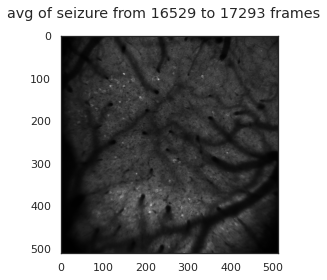

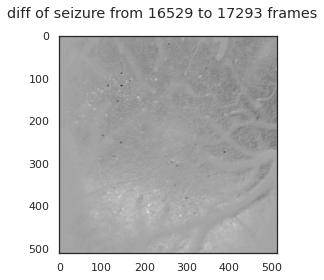

saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-238.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-386.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-534.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-683.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-831.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-979.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-1127.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-0

saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-10762.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-10911.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-11059.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-11207.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-11355.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-11504.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/avg_stim_images/2020-12-18_t-011_stim-11652.tif
saving stim_img tiff to... /home/pshah/mnt/qnap/Analysis/2020-12-18/2

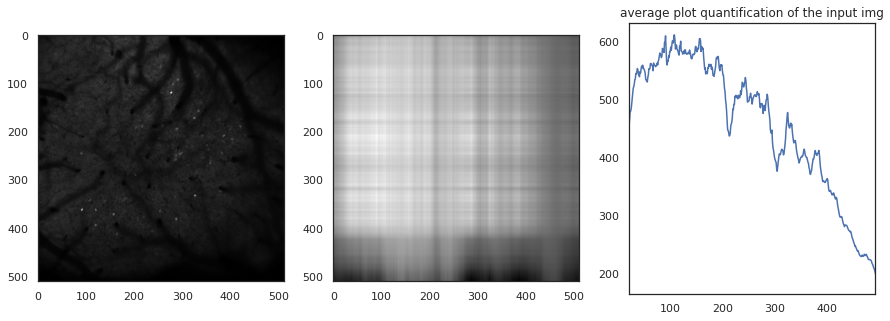

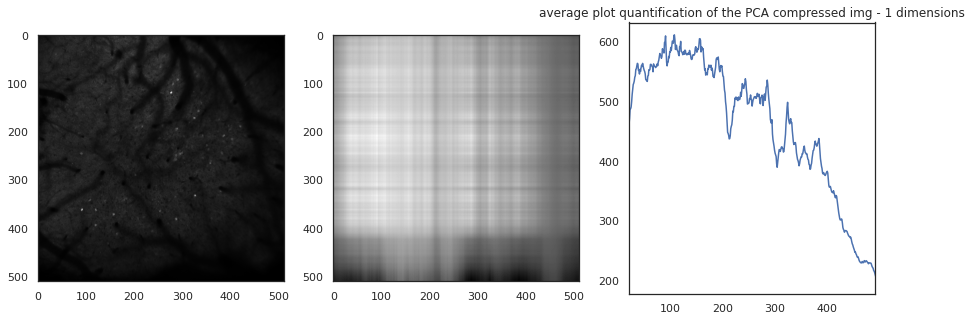

Extracting the top 1 eigendimensions from image


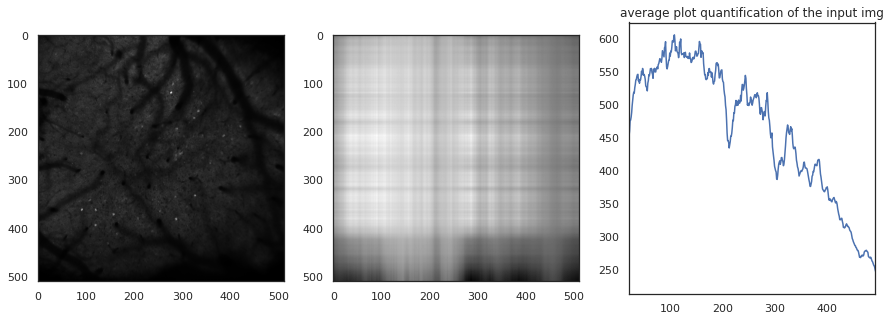

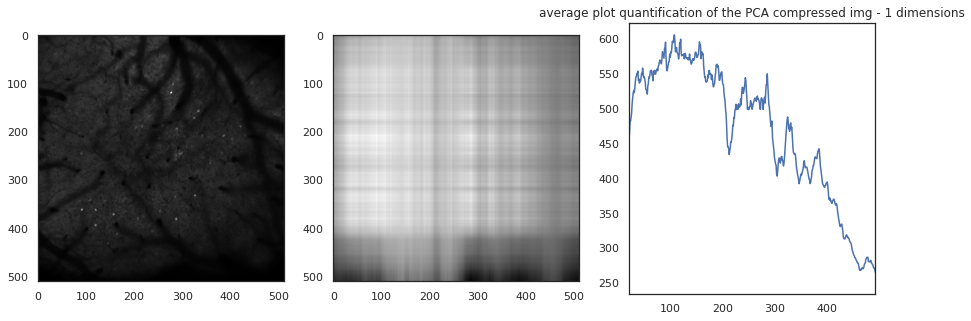

Extracting the top 1 eigendimensions from image


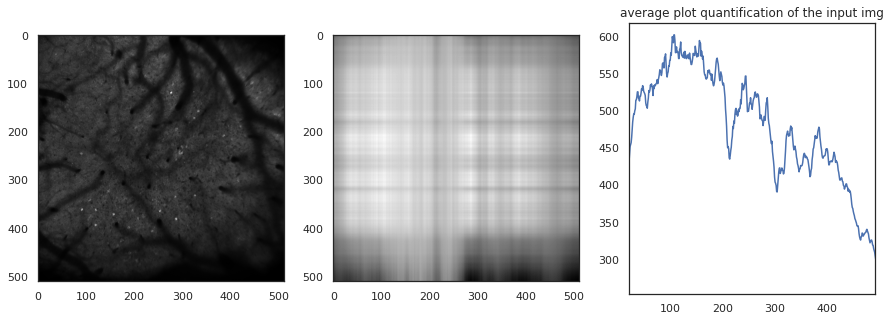

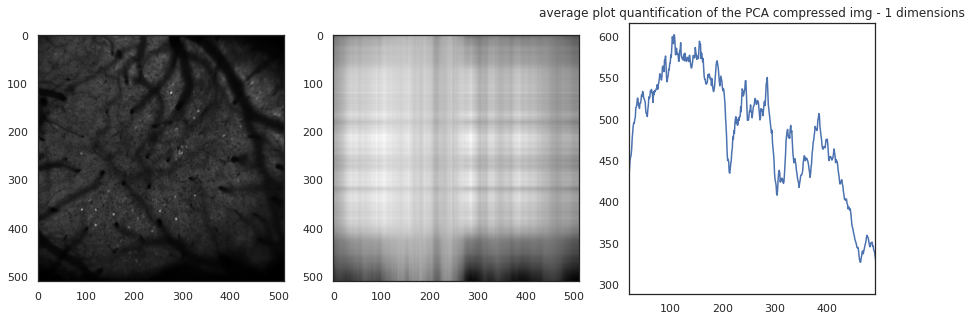

Extracting the top 1 eigendimensions from image


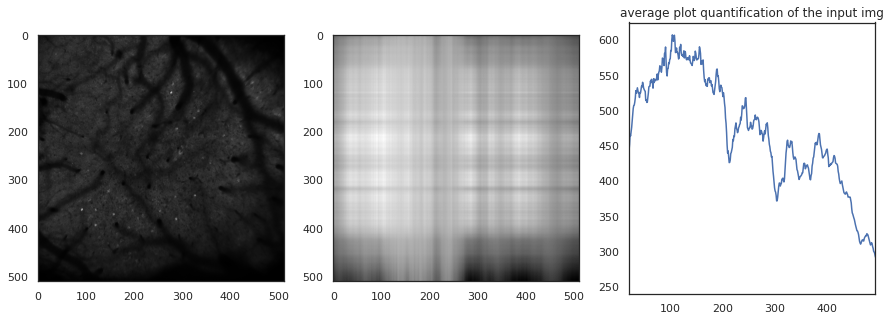

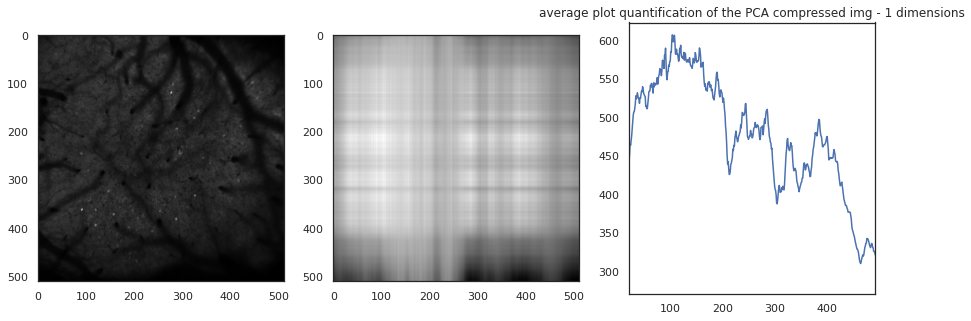

Extracting the top 1 eigendimensions from image


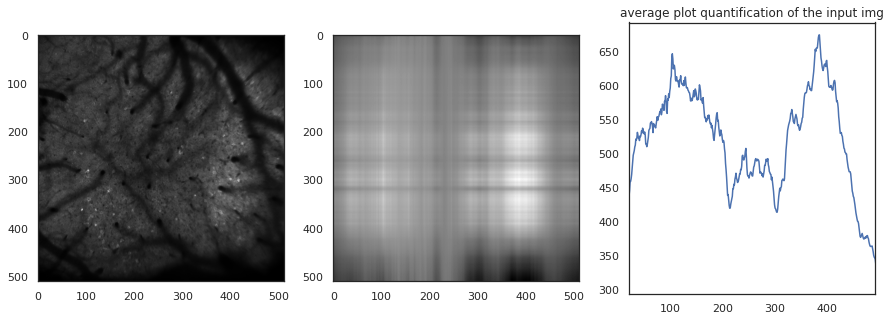

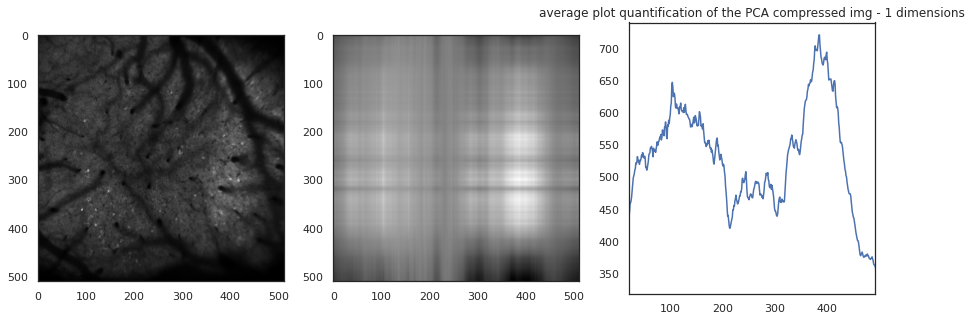

In [12]:
if 'post' in expobj.metainfo['exptype'] and '4ap' in expobj.metainfo['exptype']:
    print('\nMOVING ONTO POST-4AP SZ PROCESSING')
else:
    sys.exit()


expobj.avg_sub_l, im_sub_l, im_diff_l = expobj.avg_seizure_images(
    baseline_tiff="/home/pshah/mnt/qnap/Data/2020-12-18/2020-12-18_t-005/2020-12-18_t-005_Cycle00001_Ch3.tif",
    frames_last=1000)

# counter = 0
# for i in avg_sub_l:
#     plt.imshow(i); plt.suptitle('%s' % counter); plt.show()
#     counter += 1

expobj.avg_stim_images(stim_timings=expobj.stim_start_frames, peri_frames=50, to_plot=False, save_img=True)
expobj.save_pkl()

for i in range(len(expobj.avg_sub_l)):
    img = pj.rotate_img_avg(expobj.avg_sub_l[i], angle=90)
    # PCA decomposition of the avg_seizure images
    img_compressed = pj.pca_decomp_image(img, components=1, plot_quant=True)



|- stims_in_sz: [1572, 1720, 4092, 4240, 4388, 7798, 7946, 8094, 8242, 11207, 11355, 11504, 11652, 11800] 
|- stims_out_sz: [238, 386, 534, 683, 831, 979, 1127, 1275, 1424, 1868, 2017, 2165, 2313, 2461, 2610, 2758, 2906, 3054, 3203, 3351, 3499, 3647, 3795, 3944, 4537, 4685, 4833, 4981, 5130, 5278, 5426, 5574, 5723, 5871, 6019, 6167, 6315, 6464, 6612, 6760, 6908, 7057, 7205, 7353, 7501, 7650, 8391, 8539, 8687, 8835, 8984, 9132, 9280, 9428, 9577, 9725, 9873, 10021, 10170, 10318, 10466, 10614, 10762, 10911, 11059, 11948, 12097, 12245, 12393, 12541, 12690, 12838, 12986, 13134, 13282, 13431, 13579, 13727, 13875, 14024, 14172, 14320, 14468, 14617, 14765, 14913] 
|- stims_bf_sz: [1424, 3944, 7650, 11059] 
|- stims_af_sz: [1868, 4537, 8391, 11948]


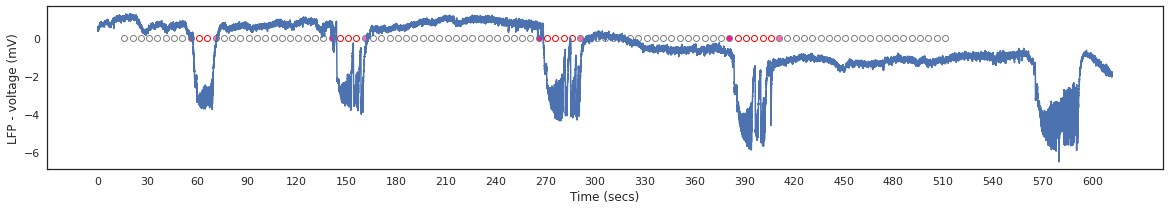

pkl saved to /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/2020-12-18_t-011.pkl


In [13]:
# %% classifying stims as in_sz or out_sz or before_sz or after_sz

expobj.stims_in_sz = [stim for stim in expobj.stim_start_frames if stim in expobj.seizure_frames]
expobj.stims_out_sz = [stim for stim in expobj.stim_start_frames if stim not in expobj.seizure_frames]
expobj.stims_bf_sz = [stim for stim in expobj.stim_start_frames
                      for sz_start in expobj.seizure_lfp_onsets
                      if 0 < (sz_start - stim) < 5 * expobj.fps]  # select stims that occur within 5 seconds before of the sz onset
expobj.stims_af_sz = [stim for stim in expobj.stim_start_frames
                      for sz_start in expobj.seizure_lfp_offsets
                      if 0 < -1 * (sz_start - stim) < 5 * expobj.fps]  # select stims that occur within 5 seconds afterof the sz offset
print('\n|- stims_in_sz:', expobj.stims_in_sz, '\n|- stims_out_sz:', expobj.stims_out_sz,
      '\n|- stims_bf_sz:', expobj.stims_bf_sz, '\n|- stims_af_sz:', expobj.stims_af_sz)
aoplot.plot_lfp_stims(expobj)
expobj.save_pkl()


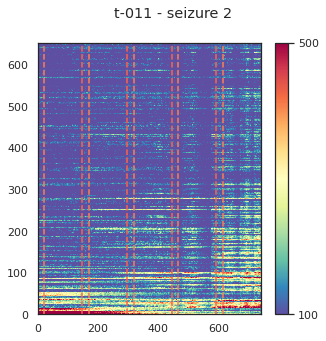

In [2]:
# %% PLOT seizure period as heatmap

sz = 2
sz_onset, sz_offset = expobj.stims_bf_sz[sz], expobj.stims_af_sz[sz]
x = expobj.raw[[expobj.cell_id.index(cell) for cell in expobj.good_cells], sz_onset:sz_offset]
stims = [(stim - sz_onset) for stim in expobj.stim_start_frames if sz_onset <= stim < sz_offset]
stims_off = [(stim + expobj.duration_frames - 1) for stim in stims]
aoplot.plot_traces_heatmap(x, stim_on=stims, stim_off=stims_off, cmap='Spectral_r',
                           title=('%s - seizure %s' % (trial, sz)), xlims=None, vmin=100, vmax=500)


In [8]:
# %% MAKE SUBSELECTED TIFFS OF INVIDUAL SEIZURES BASED ON THEIR START AND STOP FRAMES
on_ = []
# on_ = [expobj.stim_start_frames[0]]  # uncomment if imaging is starting mid seizure
on_.extend(expobj.stims_bf_sz)
expobj._subselect_sz_tiffs(onsets=on_, offsets=expobj.stims_af_sz)



-----Making raw sz movies by cropping original raw tiff
reading in seizure trial from:  /home/pshah/mnt/qnap/Data/2020-12-18/2020-12-18_t-011/2020-12-18_t-011_Cycle00001_Ch3.tif 

cropping sz frames (1424, 1868)
cropping sz frames (3944, 4537)
cropping sz frames (7650, 8391)
cropping sz frames (11059, 11948)

done. saved to: /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/


working on classifying cells for stims start frames:
|- [1424, 1572, 1720, 1868]


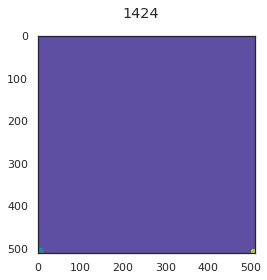

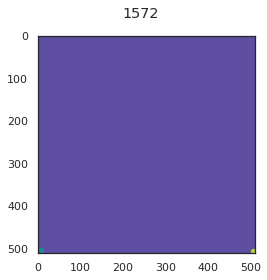

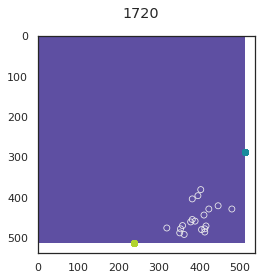

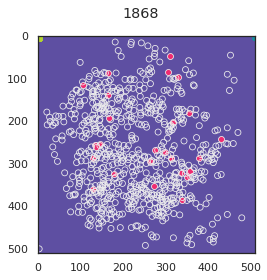

|- [3944, 4092, 4240, 4388, 4537]


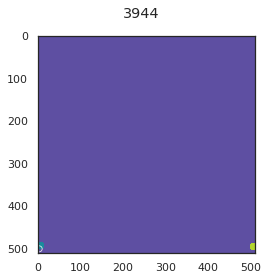

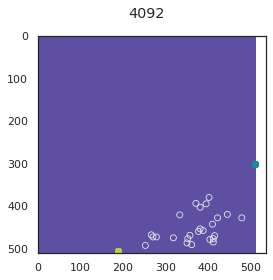

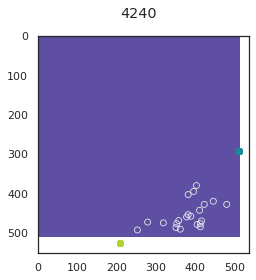

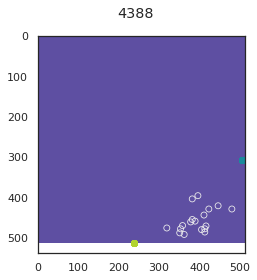

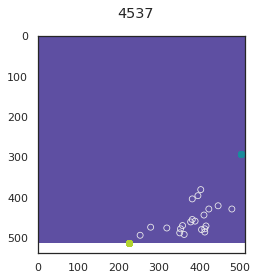

|- [7650, 7798, 7946, 8094, 8242, 8391]


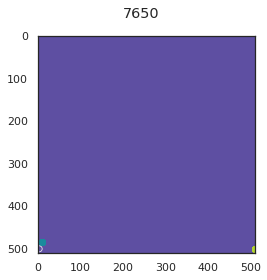

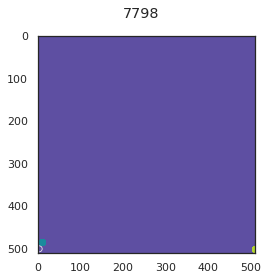

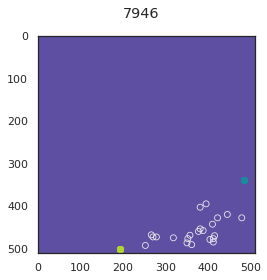

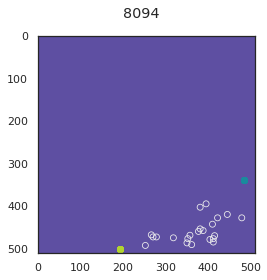

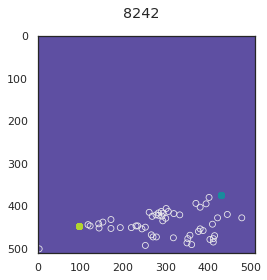

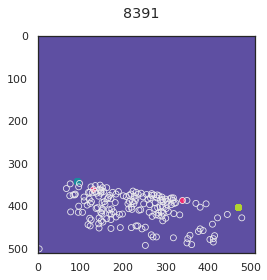

|- [11059, 11207, 11355, 11504, 11652, 11800, 11948]


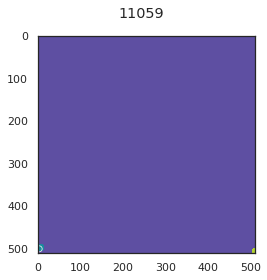

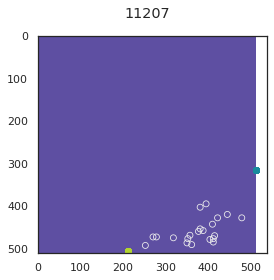

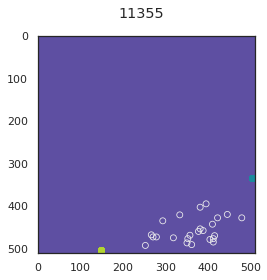

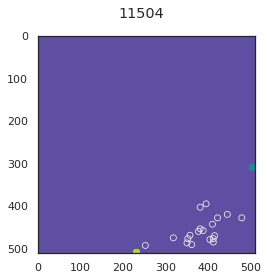

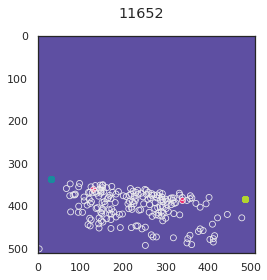

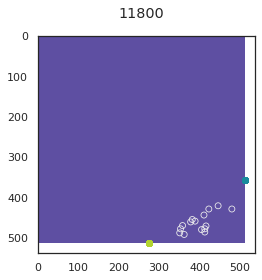

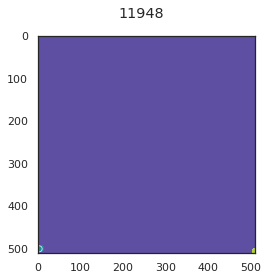

In [9]:
# %% classifying cells as in or out of the current seizure location in the FOV

# FRIST manually draw boundary on the image in ImageJ and save results as CSV to analysis folder under boundary_csv
if cont_inue:
    pass
else:
    sys.exit()

# import the CSV file in and classify cells by their location in or out of seizure

# moved this to utils.funcs_pj
def plot_cell_loc(expobj, cells: list, color: str = 'pink', show: bool = True):
    """
    plots an image of the FOV to show the locations of cells given in cells list.
    :param expobj: alloptical or 2p imaging object
    :param color: str to specify color of the scatter plot for cells
    :param cells: list of cells to plot
    :param show: if True, show the plot at the end of the function
    """
    black = np.zeros((expobj.frame_x, expobj.frame_x), dtype='uint16')
    plt.imshow(black)

    for cell in cells:
        y, x = expobj.stat[cell]['med']
        plt.scatter(x=x, y=y, edgecolors=color, facecolors='none', linewidths=0.8)

    if show:
        plt.show()
# csv_path = "/home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-013/2020-12-18_t-013_post_border.csv"

# need to run this twice to correct for mis-assignment of cells (look at results and then find out which stims need to be flipped)
expobj.not_flip_stims = [1868]  # specify here the stims where the flip=False leads to incorrect assignment
cont_inue2 = True

print('working on classifying cells for stims start frames:')
expobj.cells_sz_stim = {}
for on, off in zip(on_, expobj.stims_af_sz):
    stims_of_interest = [stim for stim in expobj.stim_start_frames if on <= stim <= off]
    print('|-', stims_of_interest)

    for stim in stims_of_interest:
        sz_border_path = "%s/boundary_csv/2020-12-18_%s_stim-%s.tif_border.csv" % (expobj.analysis_save_path[:-1], trial, stim)
        if stim in expobj.not_flip_stims:
            flip = False
        else:
            flip = True

        in_sz = expobj.classify_cells_sz(sz_border_path, to_plot=True, title='%s' % stim, flip=flip)
        expobj.cells_sz_stim[stim] = in_sz  # for each stim, there will be a list of cells that will be classified as in seizure or out of seizure
# expobj.save()

if cont_inue2:
    pass
else:
    sys.exit()

#### processing steps for ALL OPTICAL PHOTOSTIM related stuff

In [16]:
# %% Collect pre to post stim traces for PHOTOSTIM TARGETED CELLS, FILTER FOR GOOD PHOTOSTIM. TARGETED CELLS with responses above threshold = 1 std of the prestim std

expobj.pre_stim = 15  # specify pre-stim and post-stim periods of analysis and plotting
expobj.post_stim = 150

# function for gathering all good photostim cells who respond on average across all trials to the photostim
# note that the threshold for this is 1 * std of the prestim raw flu (fluorescence trace)
expobj.targets_dff, expobj.targets_dff_avg, expobj.targets_dfstdF, \
    expobj.targets_dfstdF_avg, expobj.targets_raw, expobj.targets_raw_avg = \
    aoutils.get_targets_stim_traces_norm(expobj=expobj, normalize_to='pre-stim', pre_stim=expobj.pre_stim,
                                         post_stim=expobj.post_stim)

aoutils._good_photostim_cells(expobj=expobj, pre_stim=expobj.pre_stim, post_stim=expobj.post_stim, dff_threshold=None)

# what does threshold value mean? add more descriptive print output for that

# Collect pre to post stim traces for NON-TARGETS

expobj.dff_traces, expobj.dff_traces_avg, expobj.dfstdF_traces, \
    expobj.dfstdF_traces_avg, expobj.raw_traces, expobj.raw_traces_avg = \
    aoutils.get_nontargets_stim_traces_norm(expobj=expobj, normalize_to='pre-stim', pre_stim=expobj.pre_stim,
                                            post_stim=expobj.post_stim)


Cell #0 - dFF post-stim: 5.265708923691411 (threshold value = 1.6321633444262678)
Cell #1 - dFF post-stim: 7.82867312792348 (threshold value = 2.8416496612964783)
Cell #2 - dFF post-stim: 7.888538676215086 (threshold value = 4.437170786561649)
Cell #5 - dFF post-stim: 32.39564665955064 (threshold value = 2.723908955332988)
Cell #7 - dFF post-stim: 9.241717241918538 (threshold value = 3.271570255851631)
Cell #17 - dFF post-stim: 8.84556312972151 (threshold value = 5.107539311590916)
Cell #27 - dFF post-stim: 20.301146476582414 (threshold value = 2.245757204024136)
Cell #31 - dFF post-stim: 11.485151461171595 (threshold value = 5.374419698111463)
Cell #47 - dFF post-stim: 27.251568029230217 (threshold value = 4.7642222891908235)
Cell #51 - dFF post-stim: 28.738479118027705 (threshold value = 7.1889877388311145)
Cell #54 - dFF post-stim: 3.5254058326817237 (threshold value = 2.582430056232333)
Cell #60 - dFF post-stim: 10.711222777557824 (threshold value = 2.9529833839864805)
Cell #137 - 

In [17]:
#%% turn important cell x time arrays into pandas dataframes

# raw Flu traces of all good cells
columns = [f'{num}' for num in range(expobj.curr_trial_frames[0], expobj.curr_trial_frames[1])]
index = [f'{num}' for num in expobj.good_cells]
idxs = [expobj.cell_id.index(cell) for cell in expobj.good_cells]
expobj.raw_df = pd.DataFrame(expobj.raw[idxs, :], columns=columns, index=index)


# raw baseline Flu traces of all good cells
columns = [f'{num}' for num in range(baseline_frames[0], baseline_frames[1])]
index = [f'{num}' for num in expobj.good_cells]
idxs = [expobj.cell_id.index(cell) for cell in expobj.good_cells]
expobj.baseline_raw_df = pd.DataFrame(expobj.baseline_raw[idxs, :], columns=columns, index=index)



In [18]:
# %% calculate dFF responses of all cells to photostimulation trials expobj

# non-targeted cells: calculate response of non-targeted cells in response to photostim. trials
# - make a pandas dataframe that contains the post-stim response of all cells at each stim timepoint
#   give group name 'non_targets' to the non-targetted cells, and the appropriate SLM group number to targetted cells


expobj.dff_responses_all_cells = aoutils.all_cell_responses_dff(expobj, normalize_to='pre-stim')

# calculate the avg response values for all cells across all stims
average_responses = np.mean(expobj.dff_responses_all_cells[expobj.dff_responses_all_cells.columns[1:]], axis=1)
responses = {'cell_id': [], 'group': [], 'Avg. dFF response': []}
for cell in expobj.good_cells:
    if cell in expobj.s2p_cell_targets:
        responses['cell_id'].append(cell)
        responses['group'].append('photostim target')
        responses['Avg. dFF response'].append(average_responses[cell])
    else:
        responses['cell_id'].append(cell)
        responses['group'].append('non-target')
        responses['Avg. dFF response'].append(average_responses[cell])

expobj.average_responses_df = pd.DataFrame(responses)

print('\nThe avg. dF/F responses of photostim targets is: %s' % np.mean(
    expobj.average_responses_df[expobj.average_responses_df.group == 'photostim target'])[1])


Completed gathering dFF responses to photostim for 653 cells
risky cells (with low Flu values to normalize with):  [9, 120, 144, 146, 177, 181, 188, 222, 248, 282, 305, 314, 320, 329, 331, 333, 334, 341, 346, 347, 359, 372, 378, 401, 402, 443, 444, 451, 454, 478, 481, 484, 500, 502, 523, 537, 559, 560, 570, 571, 587, 606, 610, 653, 670, 685, 715, 724, 725, 751, 753, 758, 778, 804, 809, 820, 821, 828, 830, 881, 895, 896, 904, 912, 923, 943, 1004, 1016, 1066, 1092, 1117, 1144, 1194, 1196, 1243, 1264, 1272, 1291, 1318, 1347, 1352, 1359, 1367, 1395, 1413, 1445, 1544, 1632, 1644, 1659, 1678, 1777, 1794, 1805, 1832, 1836, 1840, 1925, 1955, 1959, 1988, 1989, 2003, 2011, 2061, 2087, 2128, 2253, 2288, 2309]

The avg. dF/F responses of photostim targets is: 11.667088238751447


In [19]:
# %% calculate dF_stdF responses of all cells to photostimulation trials expobj

expobj.dfstdf_all_cells = aoutils.all_cell_responses_dFstdF(expobj)

# calculate the avg response values for all cells across all stims
average_responses_dfstdf = np.mean(expobj.dfstdf_all_cells[expobj.dfstdf_all_cells.columns[1:]], axis=1)
responses = {'cell_id': [], 'group': [], 'Avg. dF/stdF response': []}
for cell in expobj.good_cells:
    if cell in expobj.s2p_cell_targets:
        responses['cell_id'].append(cell)
        responses['group'].append('photostim target')
        responses['Avg. dF/stdF response'].append(average_responses_dfstdf[cell])
    else:
        responses['cell_id'].append(cell)
        responses['group'].append('non-target')
        responses['Avg. dF/stdF response'].append(average_responses_dfstdf[cell])

expobj.average_responses_dfstdf = pd.DataFrame(responses)

print('\nThe avg. dF/stdF responses of photostim targets is: %s' % np.mean(
    expobj.average_responses_dfstdf[expobj.average_responses_dfstdf.group == 'photostim target'])[1])

expobj.save()

Completed gathering dF/stdF responses to photostim for 653 cells

The avg. dF/stdF responses of photostim targets is: 0.24834934084503735
pkl saved to /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/2020-12-18_t-011.pkl


In [20]:
sys.exit()

SystemExit: 

/home/pshah/anaconda3/envs/2021/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## alloptical photostim analysis - t-011

trials: ['t-010'] -- pre 4ap all optical -- no seizures, discard all frames = true

NAPARM export: 2020-12-18_RL108_ps_009

In [1]:
# %% IMPORT MODULES AND TRIAL expobj OBJECT
import sys

sys.path.append('/home/pshah/Documents/code/PackerLab_pycharm/')
sys.path.append('/home/pshah/Documents/code/')
import alloptical_utils_pj as aoutils
import alloptical_plotting as aoplot
import utils.funcs_pj as pj

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import draw

###### IMPORT pkl file containing data in form of expobj
trial = 't-011'
date = '2020-12-18'
pkl_path = "/home/pshah/mnt/qnap/Analysis/%s/%s_%s/%s_%s.pkl" % (date, date, trial, date, trial)
# pkl_path = "/home/pshah/mnt/qnap/Data/%s/%s_%s/%s_%s.pkl" % (date, date, trial, date, trial)

expobj, experiment = aoutils.import_expobj(trial=trial, date=date, pkl_path=pkl_path)


importing expobj for "2020-12-18, t-011" from: /home/pshah/mnt/qnap/Analysis/2020-12-18/2020-12-18_t-011/2020-12-18_t-011.pkl
DONE IMPORT of RL108: t-011, post 4ap all optical trial


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


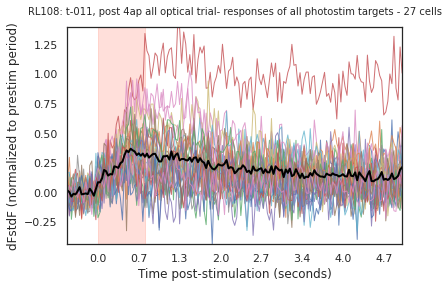

In [5]:
# %% PLOT AVG PHOTOSTIM PRE- POST- TRACE AVGed OVER ALL PHOTOSTIM. TRIALS - PHOTOSTIM TARGETTED cells

# x = np.asarray([i for i in expobj.good_photostim_cells_stim_responses_dFF[0]])
x = np.asarray([i for i in expobj.targets_dfstdF_avg])
# y_label = 'pct. dFF (normalized to prestim period)'
y_label = 'dFstdF (normalized to prestim period)'

aoplot.plot_photostim_avg(dff_array=x, expobj=expobj, stim_duration=expobj.duration_frames, pre_stim=expobj.pre_stim,
                          post_stim=expobj.post_stim,
                          title=(experiment + '- responses of all photostim targets'),
                          y_label=y_label, x_label='Time post-stimulation (seconds)')


/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


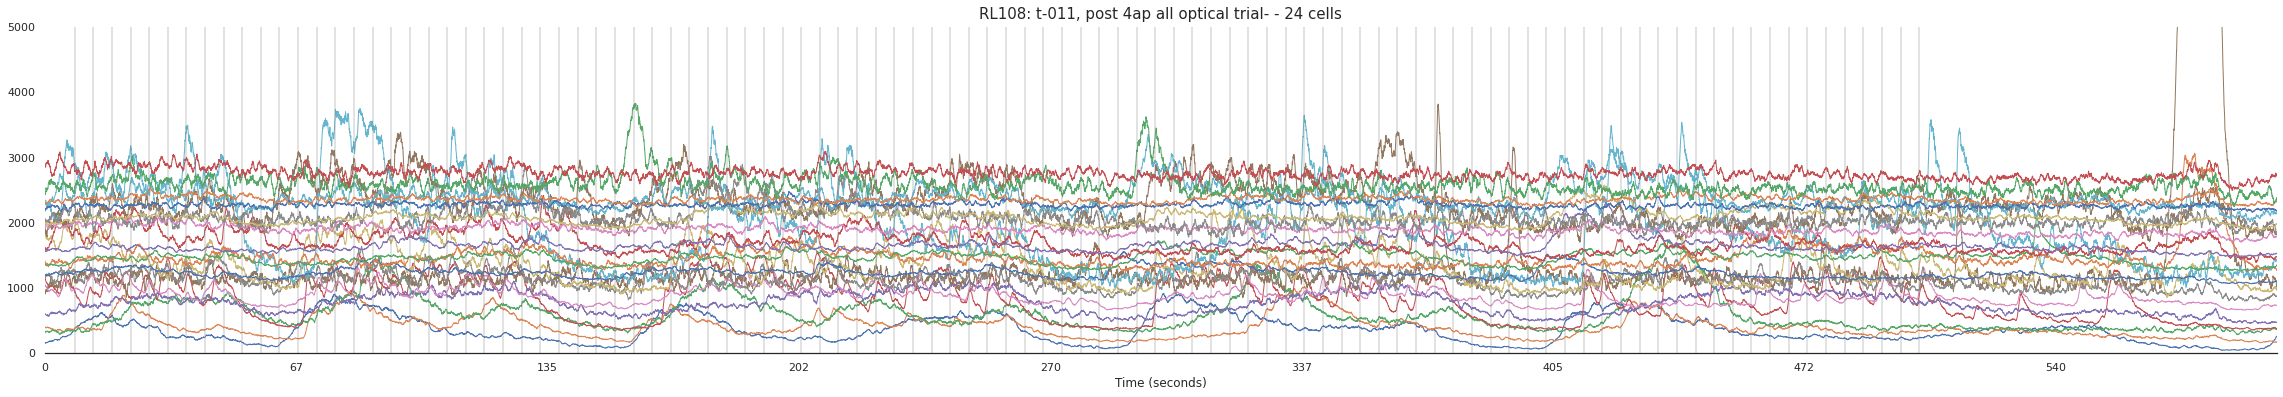

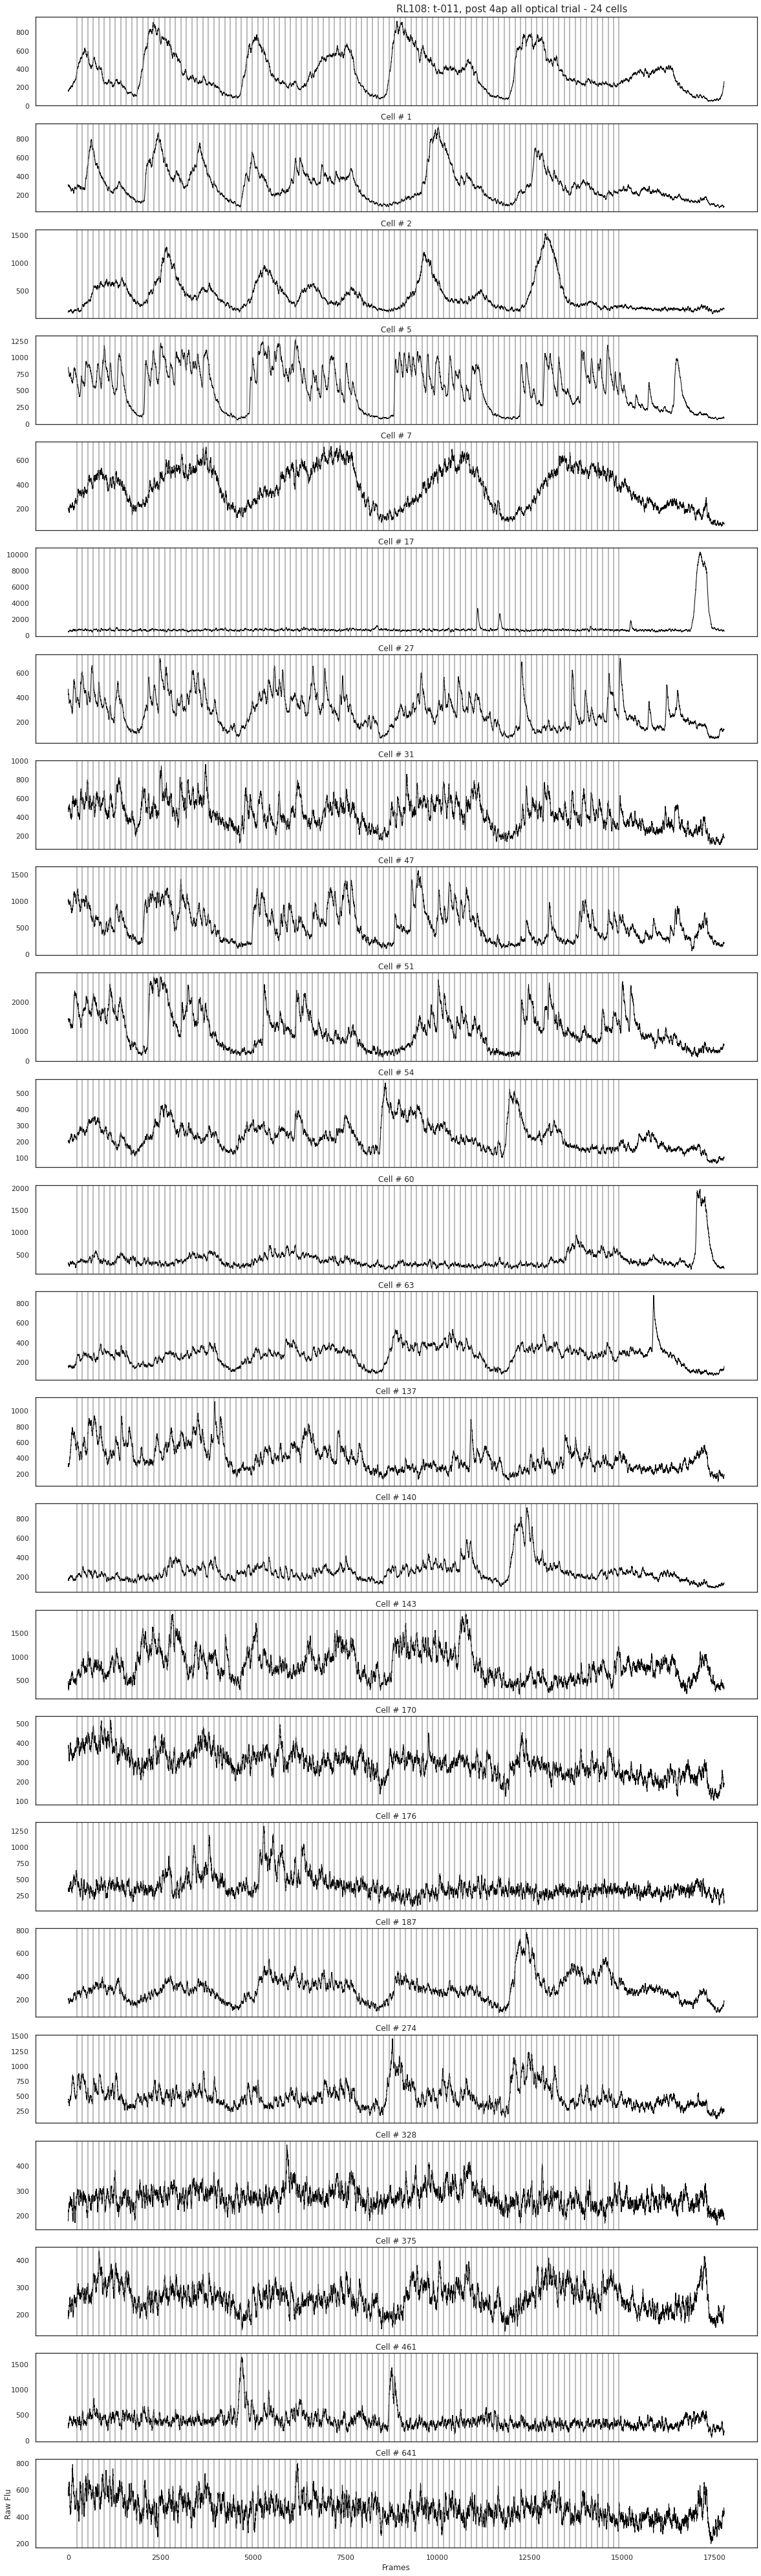

In [3]:
# %% PLOT ENTIRE TRIAL - targeted cells plotted individually as subplots

expobj.raw_targets = [expobj.raw[expobj.cell_id.index(i)] for i in expobj.good_photostim_cells_all]
expobj.dff_targets = aoutils.normalize_dff(np.array(expobj.raw_targets))
expobj.targets_dff_base = aoutils.normalize_dff_baseline(
    arr=expobj.raw_df.loc[[str(x) for x in expobj.s2p_cell_targets]],
    baseline_array=expobj.baseline_raw_df)
# plot_photostim_subplots(dff_array=dff_targets,
#                 title=(experiment + '%s responses of responsive cells' % len(expobj.good_photostim_cells_stim_responses_dFF)))
to_plot = expobj.dff_targets


aoplot.plot_photostim_overlap_plots(dff_array=to_plot, expobj=expobj,
                                    y_lims=[0, 5000], title=(experiment + '-'))

aoplot.plot_photostim_subplots(dff_array=to_plot, expobj=expobj, x_label='Frames',
                               y_label='Raw Flu',
                               title=(experiment))


avg reliability is: 37.76


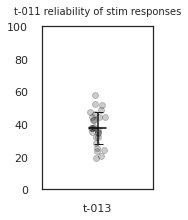

In [4]:
# %% RELIABILITY MEASUREMENTS and PLOT - PHOTOSTIM TARGETED CELLS
# measure, for each cell, the pct of trials in which the dFF > 20% post stim (normalized to pre-stim avgF for the trial and cell)
# can plot this as a bar plot for now showing the distribution of the reliability measurement

expobj.reliability = aoutils.calculate_reliability(expobj=expobj, dfstdf_threshold=0.3)
pj.bar_with_points(data=[list(expobj.reliability.values())], x_tick_labels=['t-013'], ylims=[0, 100], bar=False,
                   title='%s reliability of stim responses' % trial, expand_size_x=2)



/home/pshah/Documents/code/PackerLab_pycharm/alloptical_plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


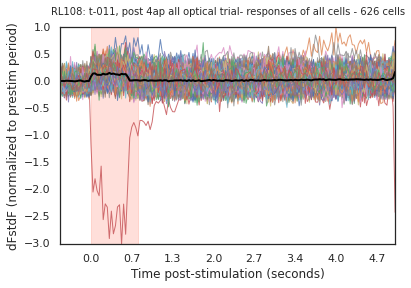

In [4]:
# %% PLOT AVG PHOTOSTIM PRE- POST- TRACE AVGed OVER ALL PHOTOSTIM. TRIALS - NON - TARGETS
x = np.asarray([i for i in expobj.dfstdF_traces_avg])
# y_label = 'pct. dFF (normalized to prestim period)'
y_label = 'dFstdF (normalized to prestim period)'

aoplot.plot_photostim_avg(dff_array=x, expobj=expobj, stim_duration=expobj.duration_frames, pre_stim=expobj.pre_stim,
                          post_stim=expobj.post_stim,
                          title=(experiment + '- responses of all cells'),
                          y_label=y_label, x_label='Time post-stimulation (seconds)')

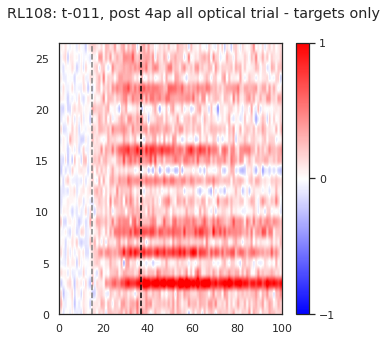

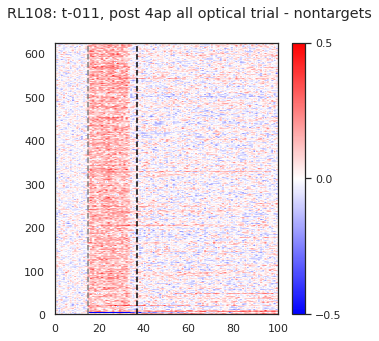

In [6]:
# %% PLOT HEATMAP OF AVG PRE- POST TRACE AVGed OVER ALL PHOTOSTIM. TRIALS - ALL CELLS (photostim targets at top) - Lloyd style :D

x = np.asarray([i for i in expobj.targets_dfstdF_avg])
aoplot.plot_traces_heatmap(x, vmin=-1, vmax=1, stim_on=expobj.pre_stim, stim_off=expobj.pre_stim + expobj.duration_frames - 1,
                           title=(experiment + ' - targets only'))

x = np.asarray([i for i in expobj.dfstdF_traces_avg])
aoplot.plot_traces_heatmap(x, vmin=-0.5, vmax=0.5, stim_on=expobj.pre_stim, stim_off=expobj.pre_stim + expobj.duration_frames - 1,
                           title=(experiment + ' - nontargets'))


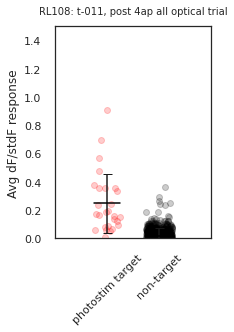

In [7]:
# %% BAR PLOT PHOTOSTIM RESPONSES SIZE - TARGETS vs. NON-TARGETS
# collect photostim timed average dff traces
all_cells_dff = []
good_std_cells = []


## using pj.bar_with_points() for a nice bar graph
group1 = list(expobj.average_responses_dfstdf[expobj.average_responses_dfstdf['group'] == 'photostim target'][
                  'Avg. dF/stdF response'])
group2 = list(
    expobj.average_responses_dfstdf[expobj.average_responses_dfstdf['group'] == 'non-target']['Avg. dF/stdF response'])
pj.bar_with_points(data=[group1, group2], x_tick_labels=['photostim target', 'non-target'], xlims=[0, 0.6],
                   ylims=[0, 1.5], bar=False,
                   colors=['red', 'black'], title=experiment, y_label='Avg dF/stdF response', expand_size_y=1.3,
                   expand_size_x=1.4)


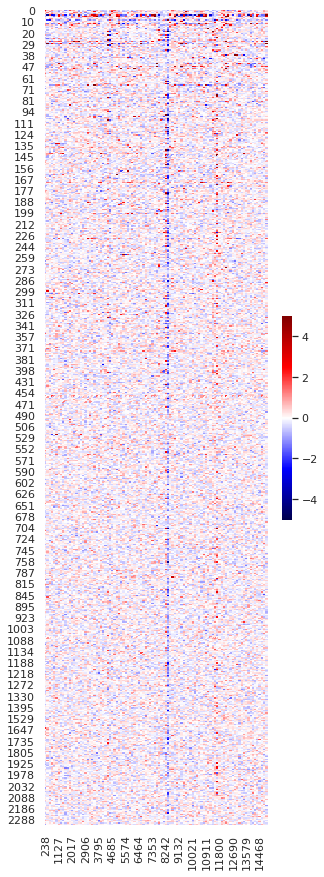

In [8]:
# %% PLOT HEATMAP OF PHOTOSTIM. RESPONSES TO PHOTOSTIM FOR ALL CELLS
# - need to find a way to sort these responses that similar cells are sorted together
# - implement a heirarchical clustering method

stim_timings = [str(i) for i in expobj.stim_start_frames]  # need each stim start frame as a str type for pandas slicing

# make heatmap of responses across all cells across all stims
df_ = expobj.dfstdf_all_cells[stim_timings]  # select appropriate stim time reponses from the pandas df
df_ = df_[df_.columns].astype(float)

plt.figure(figsize=(5, 15));
sns.heatmap(df_, cmap='seismic', vmin=-5, vmax=5, cbar_kws={"shrink": 0.25});
plt.show()


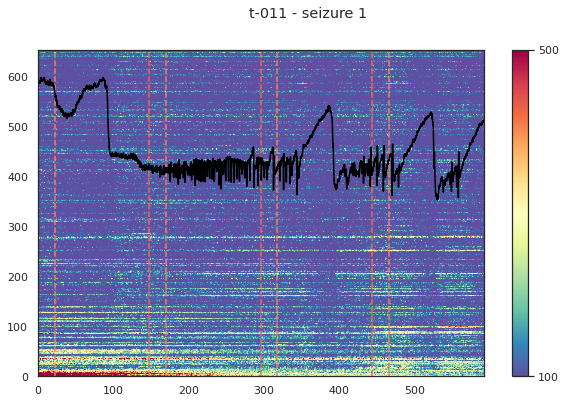

In [6]:
sz = 1
sz_onset, sz_offset = expobj.stims_bf_sz[sz], expobj.stims_af_sz[sz]
x = expobj.raw[[expobj.cell_id.index(cell) for cell in expobj.good_cells], sz_onset:sz_offset]

stims = [(stim - sz_onset) for stim in expobj.stim_start_frames if sz_onset <= stim < sz_offset]
stims_off = [(stim + expobj.duration_frames - 1) for stim in stims]

x_bf = expobj.stim_times[np.where(expobj.stim_start_frames == expobj.stims_bf_sz[sz])[0][0]]
x_af = expobj.stim_times[np.where(expobj.stim_start_frames == expobj.stims_af_sz[sz])[0][0]]

lfp_signal = expobj.lfp_signal[x_bf:x_af]

aoplot.plot_traces_heatmap(x, stim_on=stims, stim_off=stims_off, cmap='Spectral_r', figsize=(10,6),
                           title=('%s - seizure %s' % (trial, sz)), xlims=None, vmin=100, vmax=500,
                           lfp_signal=lfp_signal)
